In [1]:
import datetime
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import *
import pyspark.sql.functions as F
from pyspark.sql.types import *

/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/karna/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
DATA_FOLDER = "mentions_counts/"

In [3]:
countries = pd.read_csv(DATA_FOLDER+"countries.csv")[["ISO", "Country", "Region"]]
countries.ISO = countries.ISO.str.upper()
countries.set_index("ISO", inplace=True)

regions = countries.Region.unique()[:-1]
print("Regions list:", regions)

fips_to_iso = pd.read_csv(DATA_FOLDER+"fips-10-4-to-iso-country-codes.csv")
countries = countries.merge(fips_to_iso, how="left", left_index=True, right_on="ISO")
countries.drop(columns=["Name"], inplace=True)
countries.dropna()

countries.head(10)

Regions list: ['Asia' 'Europe' 'Africa' 'Oceania' 'Americas']


,Country,Region,FIPS,ISO
0,Afghanistan,Asia,AF,AF
278,Åland Islands,Europe,NaN,AX
2,Albania,Europe,AL,AL
3,Algeria,Africa,AG,DZ
4,American Samoa,Oceania,AQ,AS
5,Andorra,Europe,AN,AD
6,Angola,Africa,AO,AO
7,Anguilla,Americas,AV,AI
8,Antarctica,NaN,AY,AQ
9,Antigua and Barbuda,Americas,AC,AG


In [4]:
counts_file = DATA_FOLDER+"mentions_counts_by_state_and_day.csv"

In [5]:
def read_csv(path, states=None):
    counts = pd.read_csv(path)
    counts = counts.merge(countries[["Country", "ISO", "FIPS", "Region"]], how="inner", left_on="STATE", right_on="FIPS")
    counts.dropna(inplace=True)
    counts = counts.assign(DATE=pd.to_datetime(counts[["YEAR", "MONTH", "DAY"]]))
    if states is not None:
        counts = counts[counts.STATE.isin(states)]

    counts.drop(columns=["FIPS", "YEAR", "MONTH", "DAY"], inplace=True)
    counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
    counts = counts[["DATE", "STATE", "ISO", "Country", "Region", "GLOBAL_COUNT", "ENV_COUNT", "Ratio"]]
    return counts

In [6]:
counts = read_csv(counts_file,countries[countries.Region=="Europe"].FIPS.values)
counts = counts.groupby([(pd.Grouper(key='DATE',freq='W')),"Country"]).sum()
counts = counts.reset_index()
counts = counts.assign(Ratio=counts.ENV_COUNT/counts.GLOBAL_COUNT)
counts.head()

,DATE,Country,GLOBAL_COUNT,ENV_COUNT,Ratio
0,2015-02-22,Albania,459,157.0,0.342048
1,2015-02-22,Austria,4047,1061.0,0.262170
2,2015-02-22,Belarus,6261,1318.0,0.210510
3,2015-02-22,Belgium,7391,890.0,0.120417
4,2015-02-22,Bosnia and Herzegovina,688,72.0,0.104651


In [7]:
def sep_year(table):
    return table[table['DATE'] < '2016-01-01'], table[table['DATE'] < '2017-01-01'], table[table['DATE'] < '2018-01-01']

In [8]:
counts_2015,counts_2016,counts_2017 = sep_year(counts)

In [9]:
import altair as alt
alt.renderers.enable('notebook')

RendererRegistry.enable('notebook')

In [10]:
def circle_scatter_plot(table,year):
    x_title = "Date in %d (weekly divided)" % (year)
    
    plot = alt.Chart(table).mark_circle(
        opacity=0.8,
        stroke='black',
        strokeWidth=1
    ).encode(
        alt.X('DATE:T', axis=alt.Axis(labelAngle=0, title=x_title)),
        alt.Y('Country:N'),
        alt.Size('Ratio:Q',
            legend=alt.Legend(title='Ratio')
        ),
        alt.Color('Country:N', legend=None)
    ).properties(
        width=500,
        height=800
    ).properties(
    title='Evolution of the ratio of ecological mentions over time by country in Europe')
    
    return plot


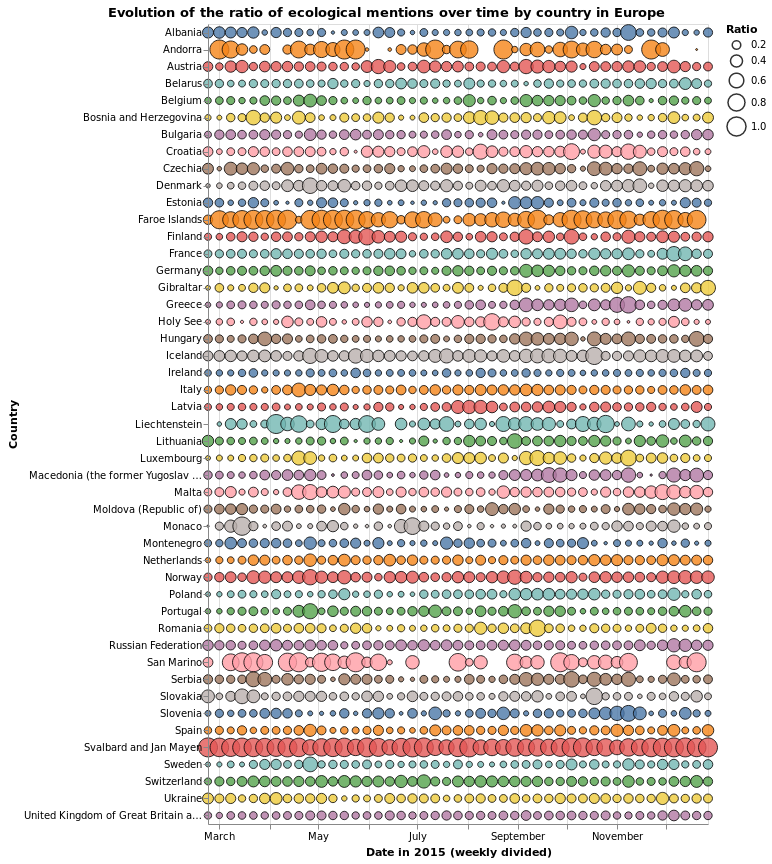

In [11]:
circle_scatter_plot(counts_2015,2015)

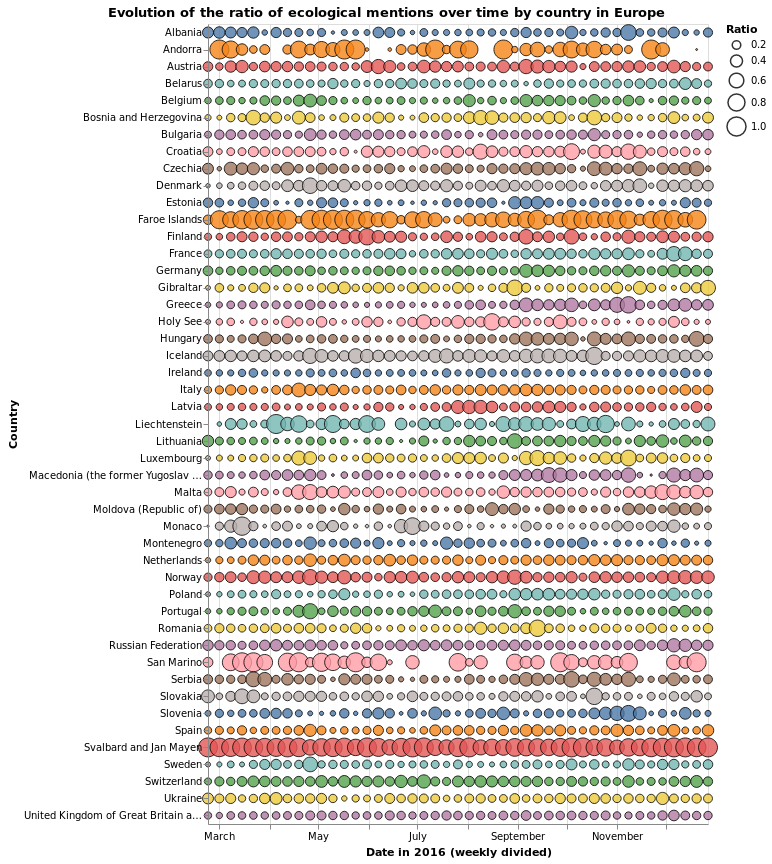

In [12]:
circle_scatter_plot(counts_2015,2016)

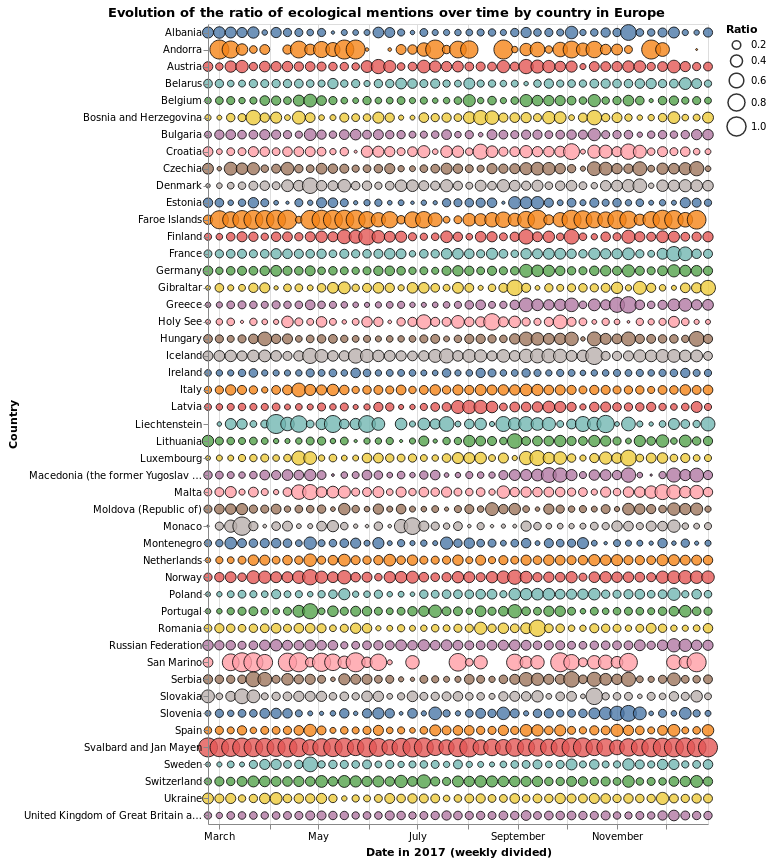

In [13]:
circle_scatter_plot(counts_2015,2017)